<a href="https://colab.research.google.com/github/nrshaidat/facial_recognition/blob/master/faceRecognitionModelsThatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning the github repo with all the necessary files to run the test images:

In [24]:
!rm -rf facial_recognition/
!git clone https://github.com/nrshaidat/facial_recognition.git

Cloning into 'facial_recognition'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 238 (delta 22), reused 68 (delta 14), pack-reused 158
Receiving objects: 100% (238/238), 147.51 MiB | 33.52 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (148/148), done.


Uses this repo's thatcher effect generator functions:
https://github.com/Erfaniaa/thatcher-effect-dataset-generator


In [0]:
import pandas as pd
from os import listdir, mkdir
from os.path import isfile, join
import cv2
from imutils import face_utils
import numpy as np
import imutils
import dlib
import matplotlib.pyplot as plt
import numpy as np

SHAPE_DETECTOR_PATH = "/content/shape_predictor_68_face_landmarks (2).dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(SHAPE_DETECTOR_PATH)

def get_image_facial_landmarks(image_path):
  ret = []
  image = plt.imread(image_path).astype(np.uint8)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    for (x, y) in shape:
      ret.append((x, y))

  return ret
INPUT_IMAGES_DIRECTORY_PATH = "/content/https___specials-images.forbesimg.com_imageserve_5c76b4b84bbe6f24ad99c370_0x0.jpg"
OUTPUT_IMAGES_DIRECTORY_PATH = "/content/"
ATTRIBUTES_CSV_PATH = "attributes.csv"
ATTRIBUTES_CSV_DELIMITER = ","
ATTRIBUTES_CSV_MAX_ROWS = 1000
PRINT_LOG = True
PRINT_LOG_PERIOD = 1
INF = 10 ** 10
def get_bounding_rectangle(points):
	top_left = [INF, INF]
	bottom_right = [-INF, -INF]
	for point in points:
		top_left[0] = min(top_left[0], point[1])
		top_left[1] = min(top_left[1], point[0])
		bottom_right[0] = max(bottom_right[0], point[1])
		bottom_right[1] = max(bottom_right[1], point[0])
	return [top_left, bottom_right]


def flip_subimage_vertically(image, x1, y1, x2, y2):
	mid_x = (x1 + x2) // 2
	for x in range(x1, mid_x):
		for y in range(y1, y2 + 1):
			image[x][y], image[x1 + x2 - x][y] = image[x1 + x2 - x][y].copy(), image[x][y].copy()


def flip_subimage_ellipse_vertically(image, x1, y1, x2, y2):
	mid_x = (x1 + x2) / 2.0
	mid_y = (y1 + y2) / 2.0
	b = (y2 - y1) / 2.0
	a = (x2 - x1) / 2.0
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			dx = x - mid_x
			dy = y - mid_y
			if (dx * dx) / (a * a) + (dy * dy) / (b * b) <= 1 and x1 + x2 - x > x:
				image[x][y], image[x1 + x2 - x][y] = image[x1 + x2 - x][y].copy(), image[x][y].copy()


def gradient_subimage(image, x1, y1, x2, y2):
	final_distance = (x2 - x1) ** 2 + (y2 - y1) ** 2
	start_color = image[x1][y1].copy()
	final_color = image[x2][y2].copy()
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			current_distance = (x - x1) ** 2 + (y - y1) ** 2
			k = current_distance / final_distance
			current_color = start_color * (1 - k) + final_color * k
			image[x][y] = current_color


def blur_ellipse_border(image, x1, y1, x2, y2):
	blurred_image = cv2.GaussianBlur(image, (5,5), 0)
	mid_x = (x1 + x2) / 2.0
	mid_y = (y1 + y2) / 2.0
	b = (y2 - y1) / 2.0
	a = (x2 - x1) / 2.0
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			dx = x - mid_x
			dy = y - mid_y
			if (dx * dx) / (a * a) + (dy * dy) / (b * b) <= 1.25 and (dx * dx) / (a * a) + (dy * dy) / (b * b) >= 0.75:
				image[x][y] = blurred_image[x][y]


def blur_orthogonal_border(image, blurred_image, x1, y1, x2, y2, border_size):
	if x1 == x2:
		for x in range(x1 - border_size, x1 + border_size + 1):
			for y in range(y1, y2 + 1):
				image[x][y] = blurred_image[x][y]
	if y1 == y2:
		for y in range(y1 - border_size, y1 + border_size + 1):
			for x in range(x1, x2 + 1):
				image[x][y] = blurred_image[x][y]


def blur_rectangle_border(image, x1, y1, x2, y2, border_size=2):
	blurred_image = cv2.GaussianBlur(image, (5,5), 0)
	blur_orthogonal_border(image, blurred_image, x1, y1, x2, y1, border_size)
	blur_orthogonal_border(image, blurred_image, x1, y2, x2, y2, border_size)
	blur_orthogonal_border(image, blurred_image, x1, y1, x1, y2, border_size)
	blur_orthogonal_border(image, blurred_image, x2, y1, x2, y2, border_size)


def flip_subimage_vertically_with_border_softening(image, x1, y1, x2, y2):
	flip_subimage_vertically(image, x1, y1, x2, y2)
	blur_rectangle_border(image, x1, y1, x2, y2)


def flip_subimage_ellipse_vertically_with_border_softening(image, x1, y1, x2, y2):
	flip_subimage_ellipse_vertically(image, x1, y1, x2, y2)
	blur_ellipse_border(image, x1, y1, x2, y2)


def apply_flipped_effect_on_image(input_image_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle):
	image = cv2.imread(input_image_path)
	flip_subimage_ellipse_vertically_with_border_softening(image, left_eye_rectangle[0][0] - 5, left_eye_rectangle[0][1] - 6, left_eye_rectangle[1][0] + 7, left_eye_rectangle[1][1] + 3)
	flip_subimage_ellipse_vertically_with_border_softening(image, right_eye_rectangle[0][0] - 5, right_eye_rectangle[0][1] - 3, right_eye_rectangle[1][0] + 7, right_eye_rectangle[1][1] + 6)
	flip_subimage_ellipse_vertically_with_border_softening(image, mouth_rectangle[0][0] - 4, mouth_rectangle[0][1] - 5, mouth_rectangle[1][0] + 3, mouth_rectangle[1][1] + 5)
	#image = cv2.flip(image, 0)
	cv2.imwrite('flipped_feat_jeff6.jpeg', image)



def main():
  input_file_path =  "/content/main-qimg-3d2015870cce23df81a6c2903071fe45.jpg"
  image_facial_landmarks = get_image_facial_landmarks(input_file_path)
  left_eye_rectangle = get_bounding_rectangle(image_facial_landmarks[36:42])
  right_eye_rectangle = get_bounding_rectangle(image_facial_landmarks[42:48])
  mouth_rectangle = get_bounding_rectangle(image_facial_landmarks[48:68])
  apply_thatcher_effect_on_image(input_file_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle)
  apply_flipped_effect_on_image(input_file_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle)
  apply_inverted_effect_on_image(input_file_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle)
  if PRINT_LOG and i % PRINT_LOG_PERIOD == 0:
    print("Done")


if __name__ == "__main__":
	main()

Done


Install necessary modules:

In [2]:
!pip install opencv-python
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.0MB/s 


VGGFACE2 Model to compare embedding distances:
Using tensorflow implementation of the VGGFace2 model:

In [28]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-z9q419mt
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-z9q419mt
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=abfd5d6d323be57d6263425a16ccc63bd7f9e778db76045b27d27438c8309215
  Stored in directory: /tmp/pip-ephem-wheel-cache-nurmionq/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


Using a pretrained FaceNet model found here  https://github.com/nyoki-mtl/keras-facenet


*    It was trained on MS-Celeb-1M dataset
*    expects input images to be:
      *   in color
      *   have their pixel values whitened (standardized across all three channels)
      *   have a square shape of 160×160 pixels


Detect faces in the dataset using the FaceNet model:

Detect faces using MTCNN and change the requiered image size from 160 (FaceNet Model) to 224 (VGGFace2 models)

In [52]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import cv2
face_dict = {}
face_dict['/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg'] = [399, 933, 47, 783]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/train/jeff_bezos/upsidedown_jeff.jpg'] = [399, 933, 47, 783]
face_dict['/content/facial_recognition/train/bill_gates/upsidedown_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg'] = [403, 723, 146, 533]
face_dict['/content/facial_recognition/train/bill_gates/upsidedown_bill2.jpg'] = [403, 723, 146, 533]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']=[717, 1668, 486, 1816]
face_dict['/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg']=[717, 1668, 486, 1816]
face_dict['/content/facial_recognition/train/elon_musk/upsidedown_elon.jpg']=[717, 1668, 486, 1816]

face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpeg'] =[103, 310, 77, 355]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill4.jpeg'] =  [268, 835, 265, 956]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill5.jpeg'] = [38, 77, 178, 195]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill6.jpeg'] = [369, 743, 1278, 1384]

face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon4.jpeg'] = [166, 635, 242, 865]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon5.jpeg'] = [377, 602, 164, 465]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon6.jpeg'] = [385, 833, 193, 812]

face_dict['/content/facial_recognition/validation/jeff_bezos/thatcher_jeff4.jpeg'] = [86, 295, 19, 304]
face_dict['/content/facial_recognition/validation/jeff_bezos/thatcher_jeff5.jpeg'] = [327, 585, 75, 444]
face_dict['/content/facial_recognition/validation/jeff_bezos/thatcher_jeff6.jpeg'] = [239, 439, 37, 307]
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		x1=face_dict[filename][0]
		x2=face_dict[filename][1]
		y1=face_dict[filename][2]
		y2=face_dict[filename][3]
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
# load images and extract faces for all images in a directory
def load_facesVal(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		face2 = cv2.flip(face,0)
		# store
		faces.append(face)
		faces.append(face2)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
# load a dataset that contains one subdir for each class that in turn contains images
def load_datasetVal(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_facesVal(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
# load train dataset
trainX, trainy = load_dataset('/content/facial_recognition/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_datasetVal('/content/facial_recognition/validation/')
# save arrays to one file in compressed format
savez_compressed('tech-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 17 examples for class: bill_gates
>loaded 17 examples for class: jeff_bezos
>loaded 17 examples for class: elon_musk
(51, 160, 160, 3) (51,)
>loaded 20 examples for class: bill_gates
>loaded 20 examples for class: jeff_bezos
>loaded 20 examples for class: elon_musk


Create Face Embeddings using FaceNet model:

In [53]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('/content/tech-faces-dataset.npz',allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('/content/facial_recognition/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('tech-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (51, 160, 160, 3) (51,) (60, 160, 160, 3) (60,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



Loaded Model
(51, 128)
(60, 128)


Extract Facial Embeddings using one of the versions of the pretrained models from the VGGFace2 Model:

*   resnet50
*   vgg16
*   senet50


In [68]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
from keras_vggface.vggface import VGGFace
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('/content/tech-faces-datasetVGG.npz',allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the VGGFACE2 model
model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('tech-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (51, 224, 224, 3) (51,) (60, 224, 224, 3) (60,)
Loaded Model
(51, 2048)
(60, 2048)


Perform Face Classification using a SVM classifier and Normalize face embeddings:

0
Predicted: bill_gates (32.828)
Expected: bill_gates


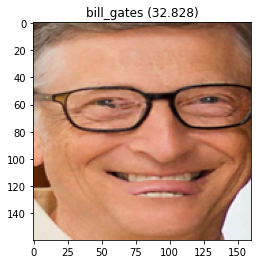

1
Predicted: bill_gates (32.730)
Expected: bill_gates


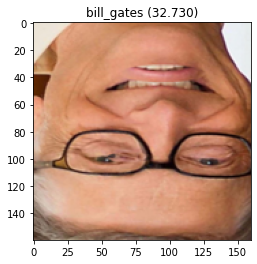

2
Predicted: bill_gates (31.894)
Expected: bill_gates


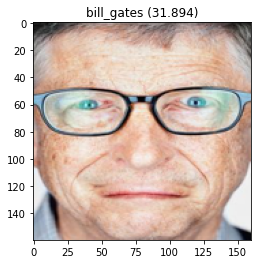

3
Predicted: bill_gates (31.950)
Expected: bill_gates


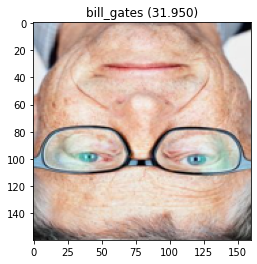

4
Predicted: bill_gates (32.878)
Expected: bill_gates


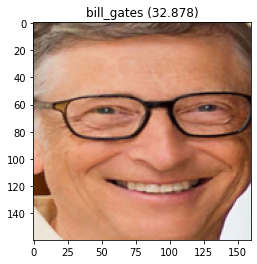

5
Predicted: bill_gates (32.776)
Expected: bill_gates


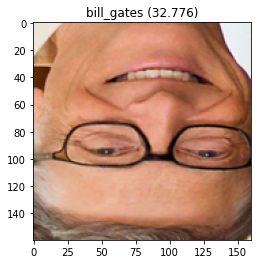

6
Predicted: bill_gates (32.939)
Expected: bill_gates


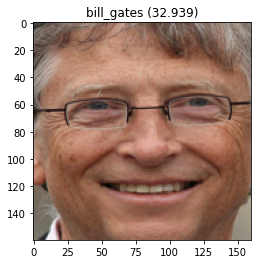

7
Predicted: bill_gates (33.030)
Expected: bill_gates


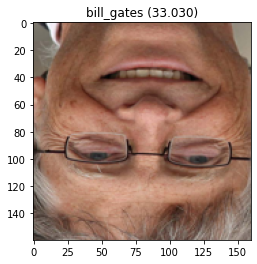

8
Predicted: bill_gates (32.639)
Expected: bill_gates


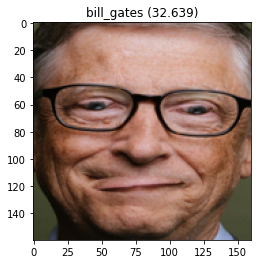

9
Predicted: bill_gates (32.746)
Expected: bill_gates


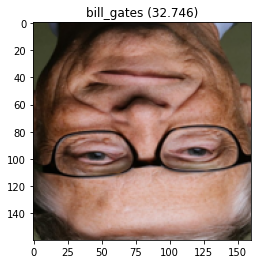

10
Predicted: bill_gates (31.877)
Expected: bill_gates


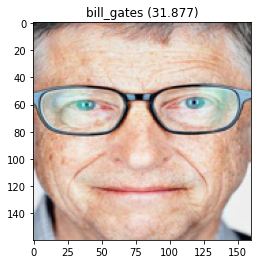

11
Predicted: bill_gates (31.953)
Expected: bill_gates


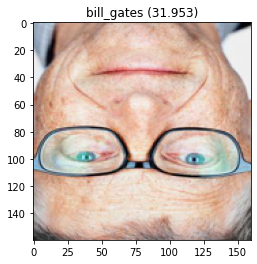

12
Predicted: bill_gates (32.906)
Expected: bill_gates


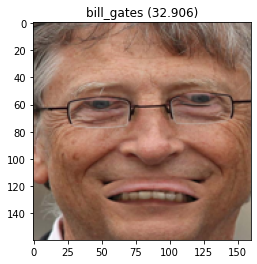

13
Predicted: bill_gates (32.881)
Expected: bill_gates


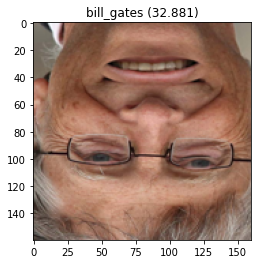

14
Predicted: jeff_bezos (33.333)
Expected: bill_gates


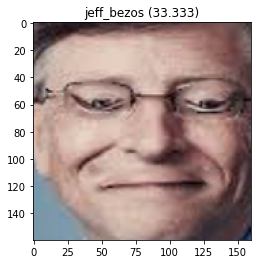

15
Predicted: jeff_bezos (33.333)
Expected: bill_gates


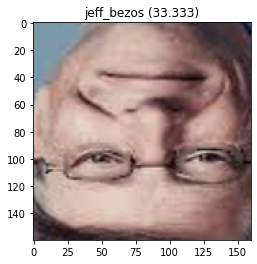

16
Predicted: jeff_bezos (33.333)
Expected: bill_gates


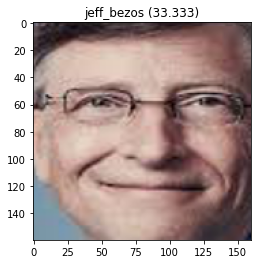

17
Predicted: jeff_bezos (33.333)
Expected: bill_gates


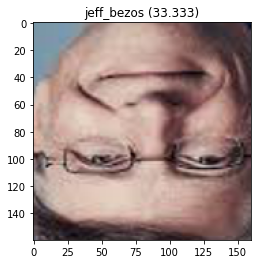

18
Predicted: bill_gates (32.752)
Expected: bill_gates


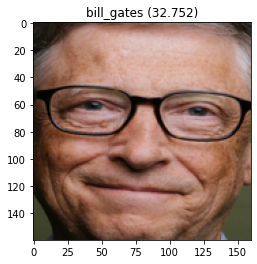

19
Predicted: bill_gates (32.728)
Expected: bill_gates


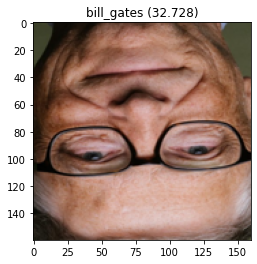

0
Predicted: jeff_bezos (33.333)
Expected: jeff_bezos


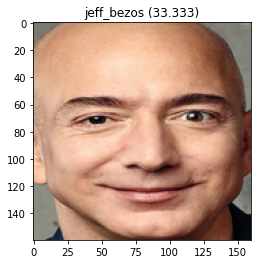

1
Predicted: jeff_bezos (33.333)
Expected: jeff_bezos


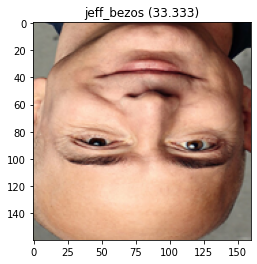

2
Predicted: elon_musk (33.113)
Expected: jeff_bezos


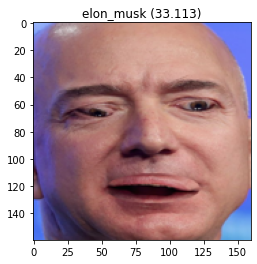

3
Predicted: elon_musk (33.102)
Expected: jeff_bezos


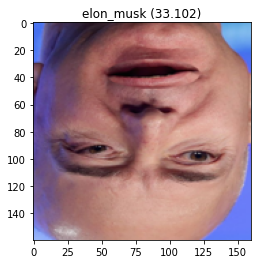

4
Predicted: jeff_bezos (33.333)
Expected: jeff_bezos


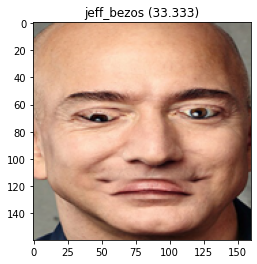

5
Predicted: bill_gates (33.126)
Expected: jeff_bezos


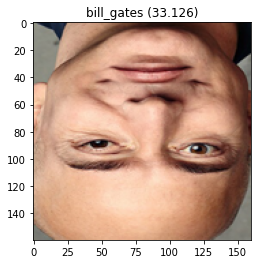

6
Predicted: elon_musk (32.867)
Expected: jeff_bezos


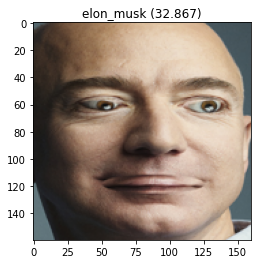

7
Predicted: elon_musk (32.886)
Expected: jeff_bezos


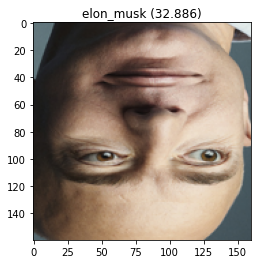

8
Predicted: elon_musk (33.058)
Expected: jeff_bezos


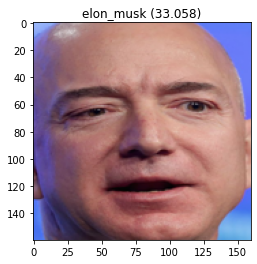

9
Predicted: elon_musk (32.943)
Expected: jeff_bezos


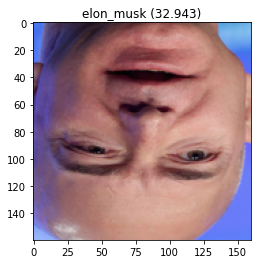

10
Predicted: jeff_bezos (33.108)
Expected: jeff_bezos


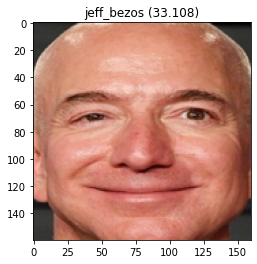

11
Predicted: jeff_bezos (33.126)
Expected: jeff_bezos


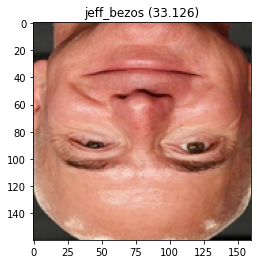

12
Predicted: elon_musk (33.130)
Expected: jeff_bezos


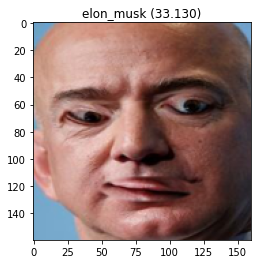

13
Predicted: jeff_bezos (33.116)
Expected: jeff_bezos


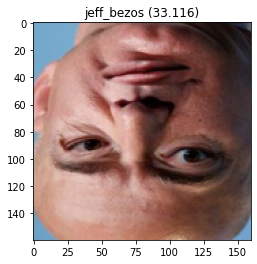

14
Predicted: elon_musk (33.124)
Expected: jeff_bezos


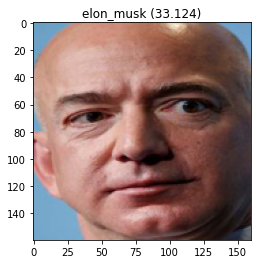

15
Predicted: jeff_bezos (33.093)
Expected: jeff_bezos


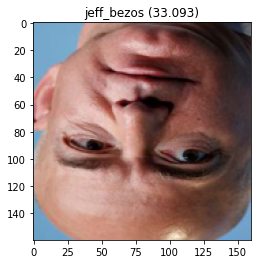

16
Predicted: elon_musk (32.897)
Expected: jeff_bezos


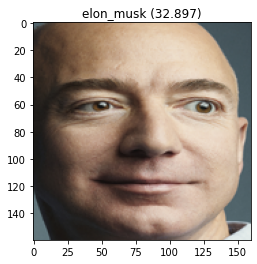

17
Predicted: elon_musk (32.850)
Expected: jeff_bezos


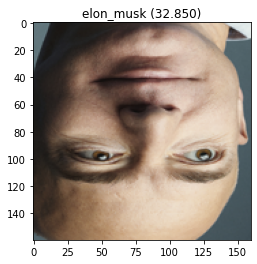

18
Predicted: elon_musk (33.138)
Expected: jeff_bezos


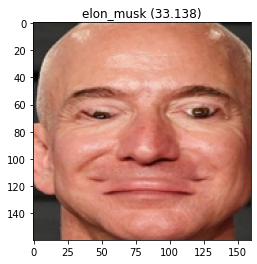

19
Predicted: jeff_bezos (33.123)
Expected: jeff_bezos


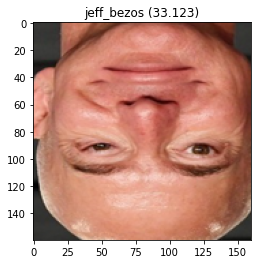

0
Predicted: jeff_bezos (33.112)
Expected: elon_musk


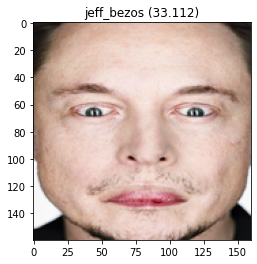

1
Predicted: jeff_bezos (33.156)
Expected: elon_musk


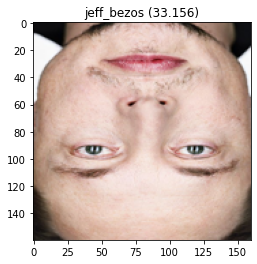

2
Predicted: elon_musk (32.972)
Expected: elon_musk


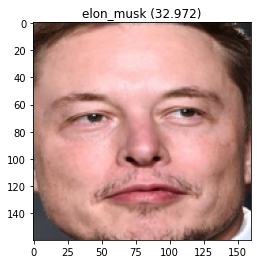

3
Predicted: elon_musk (33.103)
Expected: elon_musk


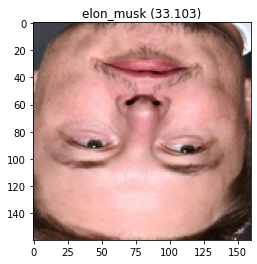

4
Predicted: elon_musk (32.533)
Expected: elon_musk


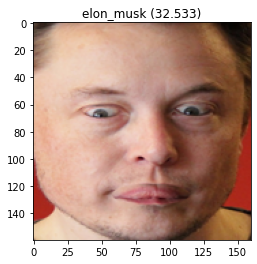

5
Predicted: elon_musk (32.682)
Expected: elon_musk


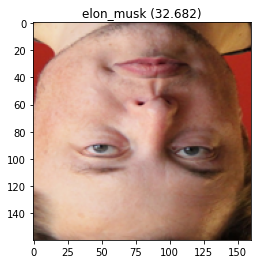

6
Predicted: elon_musk (33.089)
Expected: elon_musk


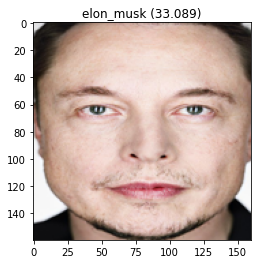

7
Predicted: jeff_bezos (33.121)
Expected: elon_musk


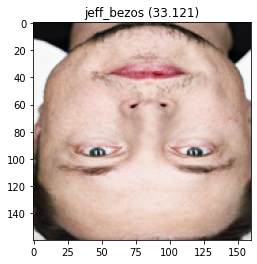

8
Predicted: jeff_bezos (33.108)
Expected: elon_musk


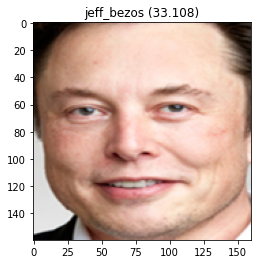

9
Predicted: jeff_bezos (33.134)
Expected: elon_musk


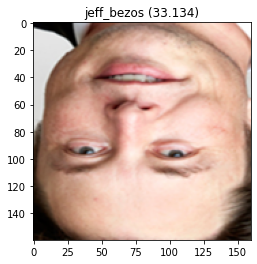

10
Predicted: elon_musk (32.516)
Expected: elon_musk


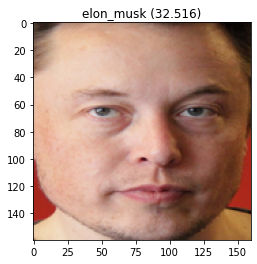

11
Predicted: elon_musk (32.728)
Expected: elon_musk


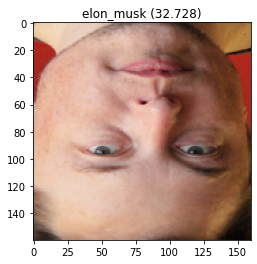

12
Predicted: elon_musk (32.663)
Expected: elon_musk


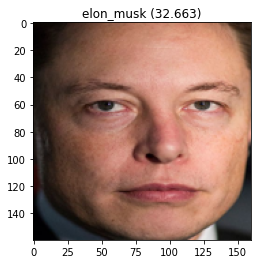

13
Predicted: elon_musk (32.705)
Expected: elon_musk


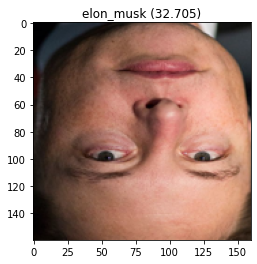

14
Predicted: elon_musk (32.656)
Expected: elon_musk


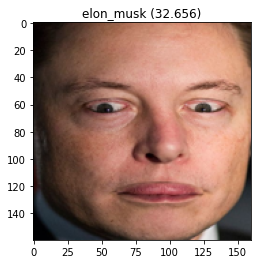

15
Predicted: elon_musk (32.701)
Expected: elon_musk


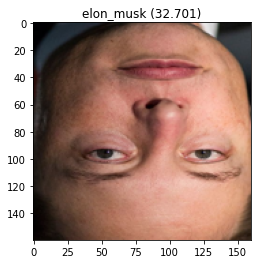

16
Predicted: jeff_bezos (33.119)
Expected: elon_musk


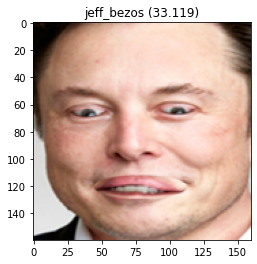

17
Predicted: jeff_bezos (33.333)
Expected: elon_musk


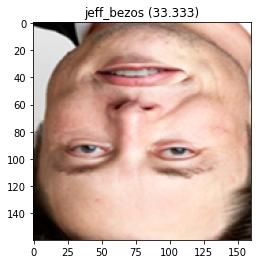

18
Predicted: elon_musk (33.017)
Expected: elon_musk


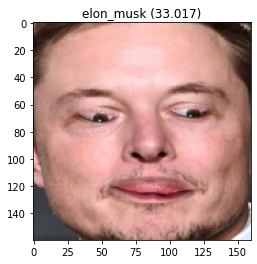

19
Predicted: elon_musk (33.061)
Expected: elon_musk


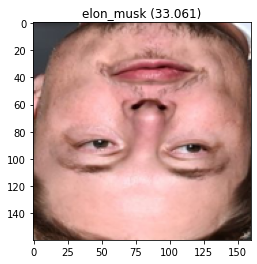

Test accuracy:  0.6166666666666667
Test f1:  0.622010122010122


In [69]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pyplot
from scipy.spatial.distance import cosine
# load faces
data = load('/content/tech-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('/content/tech-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
jeff = []
jeff_idx = 0
elon = []
elon_idx = 0
bill = []
bill_idx = 0
for i in range(testX.shape[0]):
  selection = i
  random_face_pixels = testX_faces[selection]
  random_face_emb = testX[selection]
  random_face_class = testy[selection]
  random_face_name = out_encoder.inverse_transform([random_face_class])
  if random_face_name == 'jeff_bezos':
    jeff.append(random_face_emb)
    print(jeff_idx)
    jeff_idx+=1
  if random_face_name == 'bill_gates':
    bill.append(random_face_emb)
    print(bill_idx)
    bill_idx+=1
  if random_face_name == 'elon_musk':
    elon.append(random_face_emb)
    print(elon_idx)
    elon_idx+=1
  # prediction for the face
  samples = expand_dims(random_face_emb, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
  print('Expected: %s' % random_face_name[0])
  # plot for fun
  pyplot.imshow(random_face_pixels)
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  pyplot.title(title)
  pyplot.show()
yhat = model.predict(testX)
print('Test accuracy: ', accuracy_score(testy,yhat))
print('Test f1: ', f1_score(testy,yhat, average='weighted'))

Calculate the differences between the upright and inverted images:

In [70]:
from scipy.spatial.distance import cosine
y = []
#Jeff distances
dist_jeff_inverted = cosine(jeff[1], jeff[5]) #grey background
y.append(dist_jeff_inverted)
dist_jeff_upright = cosine(jeff[0], jeff[4]) #grey background
y.append(dist_jeff_upright)
dist_jeff_inverted2 = cosine(jeff[3], jeff[9]) #blue background
y.append(dist_jeff_inverted2)
dist_jeff_upright2 = cosine(jeff[2], jeff[8]) #blue background
y.append(dist_jeff_upright2)
dist_jeff_inverted3 = cosine(jeff[7], jeff[17]) #blue background
y.append(dist_jeff_inverted3)
dist_jeff_upright3 = cosine(jeff[6], jeff[16]) #blue background
y.append(dist_jeff_upright3)
dist_jeff_inverted4 = cosine(jeff[11], jeff[19]) #blue background
y.append(dist_jeff_inverted4)
dist_jeff_upright4 = cosine(jeff[10], jeff[18]) #blue background
y.append(dist_jeff_upright4)
dist_jeff_inverted5 = cosine(jeff[13], jeff[15]) #blue background
y.append(dist_jeff_inverted5)
dist_jeff_upright5 = cosine(jeff[12], jeff[14]) #blue background
y.append(dist_jeff_upright5)
if dist_jeff_upright > dist_jeff_inverted:
  print("******Jeff 1 shows thatcher effect******")
if dist_jeff_upright2 > dist_jeff_inverted2:
  print("******Jeff 2 shows thatcher effect******")
if dist_jeff_upright3 > dist_jeff_inverted3:
  print("******Jeff 3 shows thatcher effect******")
if dist_jeff_upright4 > dist_jeff_inverted4:
  print("******Jeff 4 shows thatcher effect******")
if dist_jeff_upright5 > dist_jeff_inverted5:
  print("******Jeff 5 shows thatcher effect******")
#Elon distances 
dist_elon_inverted = cosine(elon[1], elon[7])#red background
y.append(dist_elon_inverted)
dist_elon_upright = cosine(elon[0], elon[6])#red background
y.append(dist_elon_upright)
dist_elon_inverted2 = cosine(elon[3], elon[19]) #white background
y.append(dist_elon_inverted2)
dist_elon_upright2 = cosine(elon[2], elon[18]) #white background
y.append(dist_elon_upright2)
dist_elon_inverted3 = cosine(elon[5], elon[11]) #white background
y.append(dist_elon_inverted3)
dist_elon_upright3 = cosine(elon[4], elon[10]) #white background
y.append(dist_elon_upright3)
dist_elon_inverted4 = cosine(elon[9], elon[17]) #white background
y.append(dist_elon_inverted4)
dist_elon_upright4 = cosine(elon[8], elon[16]) #white background
y.append(dist_elon_upright4)
dist_elon_inverted5 = cosine(elon[13], elon[15]) #white background
y.append(dist_elon_inverted5)
dist_elon_upright5 = cosine(elon[12], elon[14]) #white background
y.append(dist_elon_upright5)
if dist_elon_upright > dist_elon_inverted:
  print("******Elon 1 shows thatcher effect******")
if dist_elon_upright2 > dist_elon_inverted2:
  print("******Elon 2 shows thatcher effect******")
if dist_elon_upright3 > dist_elon_inverted3:
  print("******Elon 3 shows thatcher effect******")
if dist_elon_upright4 > dist_elon_inverted4:
  print("******Elon 4 shows thatcher effect******")
if dist_elon_upright5 > dist_elon_inverted5:
  print("******Elon 5 shows thatcher effect******")
#Bill distances 
dist_bill_inverted = cosine(bill[1], bill[5])#green background
y.append(dist_bill_inverted)
dist_bill_upright = cosine(bill[0], bill[4])#green background
y.append(dist_bill_upright)
dist_bill_inverted2 = cosine(bill[3], bill[11]) #white background
y.append(dist_bill_inverted2)
dist_bill_upright2 = cosine(bill[2], bill[10]) #white background
y.append(dist_bill_upright2)
dist_bill_inverted3 = cosine(bill[7], bill[19]) #white background
y.append(dist_bill_inverted3)
dist_bill_upright3 = cosine(bill[6], bill[18]) #white background
y.append(dist_bill_upright3)
dist_bill_inverted4 = cosine(bill[9], bill[13]) #white background
y.append(dist_bill_inverted4)
dist_bill_upright4 = cosine(bill[8], bill[12]) #white background
y.append(dist_bill_upright4)
dist_bill_inverted5 = cosine(bill[15], bill[17]) #white background
y.append(dist_bill_inverted5)
dist_bill_upright5 = cosine(bill[14], bill[16]) #white background
y.append(dist_bill_upright5)
if dist_bill_upright > dist_bill_inverted:
  print("******Bill 1 shows thatcher effect******")
if dist_bill_upright2 > dist_bill_inverted2:
  print("******Bill 2 shows thatcher effect******")
if dist_bill_upright3 > dist_bill_inverted3:
  print("******Bill 3 shows thatcher effect******")
if dist_bill_upright4 > dist_bill_inverted4:
  print("******Bill 4 shows thatcher effect******")
if dist_bill_upright5 > dist_bill_inverted5:
  print("******Bill 5 shows thatcher effect******")

******Jeff 3 shows thatcher effect******
******Elon 2 shows thatcher effect******
******Elon 4 shows thatcher effect******


Plot results for each model and print t-test results:

In [71]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import statistics 
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ydiff = []

for i in range(0,29,2):
  ydiff.append(y[i+1]-y[i]) 
#perfom one sample t test and print results 
t, p = stats.ttest_1samp(ydiff,0.0)
print(t, p)
#print sample mean
print(statistics.mean(ydiff))
fig = go.Figure(data=[
    go.Bar(x=x, y=ydiff),
])
fig.update_layout(barmode='group')
fig.show()

-6.113847096761068e-05
-2.3510935473489467 0.033892711773849546


Another way to do the classification phase:

In [0]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
face_dict = {}
face_dict['/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg'] = [399, 933, 47, 783]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg'] = [403, 723, 146, 533]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']=[717, 1668, 486, 1816]
face_dict['/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg']=[717, 1668, 486, 1816]
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		x1=face_dict[filename][0]
		x2=face_dict[filename][1]
		y1=face_dict[filename][2]
		y2=face_dict[filename][3]
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
  # extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model 
  # keeps all layers except last one that makes prediction 
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat
 
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.9):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
# determine if a candidate face is a match for a known face
def is_thatcher(known_embedding, candidate_embedding, candidate_embedding1, candidate_embedding2):
	# calculate distance between embeddings
  scoreUP = cosine(known_embedding, candidate_embedding)
  scoreDOWN = cosine(candidate_embedding1, candidate_embedding2)
  if scoreUP > scoreDOWN:
    print('>face Induces Thatcher (%.3f > %.3f)' % (scoreUP, scoreDOWN))
  else:
    print('>face Does NOT Induce Thatcher (%.3f UP < %.3f DOWN)' % (scoreUP, scoreDOWN))
#filenames1 = ['/content/facial_recognition/validation/elon_musk/e5.jpg', '/content/facial_recognition/validation/elon_musk/flipped_feat.jpg', '/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg', '/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']
#filenames2 = ['/content/facial_recognition/validation/elon_musk/e6.jpeg','/content/facial_recognition/validation/elon_musk/flipped_feat2.jpeg', '/content/facial_recognition/validation/elon_musk/upsidedown_elon2.jpeg','/content/facial_recognition/validation/elon_musk/thatcher_elon1.jpeg']
#filenames1 = ['/content/facial_recognition/validation/jeff_bezos/135ace03cda6428a60c025bea3089db987-16-jeff-bezos.2x.rhorizontal.w710.jpg','/content/facial_recognition/validation/jeff_bezos/flipped_feat2.jpg', '/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg', '/content/facial_recognition/validation/jeff_bezos/thatcher2_jeff.jpg']
#filenames2 = ['/content/facial_recognition/validation/jeff_bezos/jeff-bezos.jpg','/content/facial_recognition/validation/jeff_bezos/flipped_feat.jpg','/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff2.jpg','/content/facial_recognition/validation/jeff_bezos/thatcher_jeff-bezos.jpg' ]
filenames1 = ['/content/facial_recognition/validation/bill_gates/ap191257847753312437800429_t1070_hba82ab2fd84bf4215f48777f7a1936f2feee486f.jpg','/content/facial_recognition/validation/bill_gates/flipped_feat.jpg','/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg', '/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg' ]
#filenames2 = ['/content/facial_recognition/validation/bill_gates/Flickr_BillGates.jpg','/content/facial_recognition/validation/bill_gates/flipped_feat2.jpg','/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg','/content/facial_recognition/validation/bill_gates/thatcher_bill2.jpg' ]
filenames2 = ['/content/facial_recognition/validation/bill_gates/TELEMMGLPICT000140063746_trans++tt-PMhmmlxqdgRPvuJG6C_36TkPi4jZ3eU8IBZq6ki0.jpeg','/content/facial_recognition/validation/bill_gates/flipped_feat3.jpeg','/content/facial_recognition/validation/bill_gates/upsidedown_bill.jpeg','/content/facial_recognition/validation/bill_gates/thatcher_bill.jpeg' ]
# get embeddings file filenames
embeddings = get_embeddings(filenames1)
normal_img = embeddings[0]
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
is_match(embeddings[0], embeddings[3])
print('Thatcher Tests on Bill with no glasses')
is_thatcher(embeddings[0], embeddings[1], embeddings[2], embeddings[3])
embeddings2 = get_embeddings(filenames2)
# define normal image
normal_img2 = embeddings2[0]
is_match(embeddings2[0], embeddings2[1])
is_match(embeddings2[0], embeddings2[2])
is_match(embeddings2[0], embeddings2[3])
print('Thatcher Tests on Grey background Bill')
is_thatcher(embeddings2[0], embeddings2[1], embeddings2[2], embeddings2[3])

>face is a Match (0.160 <= 0.900)
>face is a Match (0.854 <= 0.900)
>face is a Match (0.793 <= 0.900)
Thatcher Tests on Bill with no glasses
>face Does NOT Induce Thatcher (0.160 UP < 0.192 DOWN)
>face is a Match (0.056 <= 0.900)
>face is a Match (0.724 <= 0.900)
>face is a Match (0.655 <= 0.900)
Thatcher Tests on Grey background Bill
>face Does NOT Induce Thatcher (0.056 UP < 0.115 DOWN)
